In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- Import your project's custom modules ---
# Ensure this script is run from a location where these can be imported
from dataloader import SliceDataset
from transform import SubsampleTime, PeakAwareBiPhasicWarp, VideoRotate, VideoDiffeo 
from torchvision.transforms import InterpolationMode
from einops import rearrange

/gpfs/data/karczmar-lab/workspaces/rachelgordon/micromamba/envs/recon_mri/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# In transform.py

import torch
import torch.nn.functional as F
import deepinv as dinv
import numpy as np
from deepinv.transform.base import Transform

# ... (keep your other corrected Video* classes) ...


class VideoAffine(Transform):
    r"""
    Applies a single, consistent random affine transformation to all frames of a video.
    This includes rotation, translation, scaling, and shearing.

    :param tuple[float, float] or float degrees: Range of degrees to select from.
        If degrees is a number instead of sequence like (min, max), the range of degrees
        will be (-degrees, +degrees).
    :param tuple[float, float] or float translate: Range of horizontal and vertical translations.
        The values are a fraction of the image size.
    :param tuple[float, float] or float scale: Range of scaling factor.
    :param tuple[float, float] or float shear: Range of shear degrees.
    :param str interpolation_mode: "bilinear" or "nearest".
    :param str padding_mode: "zeros", "border", or "reflection".
    """
    def __init__(self, *args, degrees=0., translate=None, scale=None, shear=None, 
                 interpolation_mode='bilinear', padding_mode='zeros', **kwargs):
        super().__init__(*args, **kwargs)
        self.degrees = self._check_input(degrees, 'degrees')
        self.translate = self._check_input(translate, 'translate') if translate is not None else None
        self.scale = self._check_input(scale, 'scale') if scale is not None else None
        self.shear = self._check_input(shear, 'shear') if shear is not None else None
        self.interpolation_mode = interpolation_mode
        self.padding_mode = padding_mode
        self.device = torch.device("cuda")

    def _check_input(self, val, name):
        if isinstance(val, (int, float)):
            if val < 0:
                raise ValueError(f"If {name} is a single number, it must be non-negative.")
            return (-val, val)
        elif isinstance(val, (list, tuple)) and len(val) == 2:
            return tuple(val)
        else:
            raise TypeError(f"{name} should be a single number or a sequence of two numbers.")

    def _get_params(self, x: torch.Tensor) -> dict:
        """Generates random affine transformation parameters."""
        angle = torch.empty(1).uniform_(self.degrees[0], self.degrees[1]).item()

        if self.translate is not None:
            max_dx = self.translate[0] * x.shape[-2]
            max_dy = self.translate[1] * x.shape[-1]
            translations = (torch.empty(1).uniform_(-max_dx, max_dx).item(),
                            torch.empty(1).uniform_(-max_dy, max_dy).item())
        else:
            translations = (0, 0)

        if self.scale is not None:
            scale_factor = torch.empty(1).uniform_(self.scale[0], self.scale[1]).item()
        else:
            scale_factor = 1.0

        if self.shear is not None:
            shear_factor = (torch.empty(1).uniform_(self.shear[0], self.shear[1]).item(),
                            torch.empty(1).uniform_(self.shear[0], self.shear[1]).item())
        else:
            shear_factor = (0.0, 0.0)

        return {'angle': angle, 'translations': translations, 'scale': scale_factor, 'shear': shear_factor}

    def _get_affine_matrix(self, B, H, W, angle, translations, scale, shear):
        """Creates the affine transformation matrix."""
        # Rotation matrix
        angle_rad = -np.pi * angle / 180.0
        cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
        rot_matrix = torch.tensor([[cos_a, -sin_a, 0], [sin_a, cos_a, 0], [0, 0, 1]], dtype=torch.float32)

        # Translation matrix
        trans_x, trans_y = translations
        trans_matrix = torch.tensor([[1, 0, -trans_x / (W/2)], [0, 1, -trans_y / (H/2)], [0, 0, 1]], dtype=torch.float32)

        # Scale matrix
        scale_matrix = torch.tensor([[1/scale, 0, 0], [0, 1/scale, 0], [0, 0, 1]], dtype=torch.float32)

        # Shear matrix
        shear_x, shear_y = -np.pi * shear[0] / 180.0, -np.pi * shear[1] / 180.0
        shear_matrix = torch.tensor([[1, -np.tan(shear_x), 0], [-np.tan(shear_y), 1, 0], [0, 0, 1]], dtype=torch.float32)

        # Combine matrices
        transform_matrix = trans_matrix @ shear_matrix @ rot_matrix @ scale_matrix
        return transform_matrix[:2, :].unsqueeze(0).repeat(B, 1, 1).to(self.device)

    def _transform(self, x: torch.Tensor, **params) -> torch.Tensor:
        if not self._check_x_5D(x):
            params = self._get_params(x)
            matrix = self._get_affine_matrix(x.shape[0], x.shape[-2], x.shape[-1], **params)
            grid = F.affine_grid(matrix, x.size(), align_corners=False)
            return F.grid_sample(x, grid, mode=self.interpolation_mode, padding_mode=self.padding_mode, align_corners=False)

        B, C, T, H, W = x.shape
        params = self._get_params(x[:, :, 0, :, :])
        matrix = self._get_affine_matrix(B, H, W, **params)
        
        # Create grid for a single batch item, then expand for video
        grid_single = F.affine_grid(matrix, (B, C, H, W), align_corners=False)
        grid_expanded = grid_single.repeat_interleave(T, dim=0)

        x_flat = dinv.physics.TimeMixin.flatten(x)
        transformed_flat = F.grid_sample(x_flat, grid_expanded, mode=self.interpolation_mode, padding_mode=self.padding_mode, align_corners=False)
        return dinv.physics.TimeMixin.unflatten(transformed_flat, batch_size=B)


class VideoElastic(Transform):
    r"""
    Applies a single, consistent random elastic deformation to all frames of a video.
    
    :param float alpha: Magnitude of the deformation. Larger values mean more distortion.
    :param float sigma: Smoothness of the deformation. Larger values mean smoother warps.
    :param str interpolation_mode: "bilinear" or "nearest".
    :param str padding_mode: "zeros", "border", or "reflection".
    """
    def __init__(self, *args, alpha=500.0, sigma=20.0, 
                 interpolation_mode='bilinear', padding_mode='zeros', **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.sigma = sigma
        self.interpolation_mode = interpolation_mode
        self.padding_mode = padding_mode

    def _get_params(self, x: torch.Tensor) -> dict:
        """Generates the random displacement field."""
        B, C, H, W = x.shape
        
        # Generate a random field and smooth it with a Gaussian filter
        dx = torch.rand(1, 1, H, W, device=x.device) * 2 - 1
        dy = torch.rand(1, 1, H, W, device=x.device) * 2 - 1
        
        # Create a Gaussian kernel for smoothing
        kernel_size = int(6 * self.sigma) + 1
        if kernel_size % 2 == 0:
            kernel_size += 1
        
        from torchvision.transforms.functional import gaussian_blur
        dx = gaussian_blur(dx, kernel_size, sigma=self.sigma)
        dy = gaussian_blur(dy, kernel_size, sigma=self.sigma)
        
        # Normalize and scale the displacement field
        dx_norm = dx / torch.max(torch.abs(dx))
        dy_norm = dy / torch.max(torch.abs(dy))
        
        displacement = torch.cat([dx_norm, dy_norm], dim=1).permute(0, 2, 3, 1) * self.alpha / W
        return {'displacement': displacement}

    def _transform(self, x: torch.Tensor, **params) -> torch.Tensor:
        if not self._check_x_5D(x):
            params = self._get_params(x)
            base_grid = self._create_base_grid(x, x.device)
            grid = base_grid + params['displacement']
            return F.grid_sample(x, grid, mode=self.interpolation_mode, padding_mode=self.padding_mode, align_corners=False)

        B, C, T, H, W = x.shape
        params = self._get_params(x[:, :, 0, :, :])
        
        # Create base identity grid
        base_grid = self._create_base_grid(x, x.device)
        
        # Add displacement to get the final deformation grid
        grid = base_grid + params['displacement']
        
        # Apply this same grid to all frames
        grid_expanded = grid.repeat_interleave(T, dim=0)
        x_flat = dinv.physics.TimeMixin.flatten(x)
        transformed_flat = F.grid_sample(x_flat, grid_expanded, mode=self.interpolation_mode, padding_mode=self.padding_mode, align_corners=False)
        return dinv.physics.TimeMixin.unflatten(transformed_flat, batch_size=B)

    def _create_base_grid(self, x, device):
        """Helper to create the base identity grid for F.grid_sample."""
        B, C, H, W = x.shape[0], x.shape[1], x.shape[-2], x.shape[-1]
        grid_y, grid_x = torch.meshgrid(torch.linspace(-1, 1, H, device=device),
                                        torch.linspace(-1, 1, W, device=device),
                                        indexing='ij')
        grid = torch.stack((grid_x, grid_y), 2)
        return grid.unsqueeze(0).repeat(B, 1, 1, 1)

In [15]:
# In transform.py
# (make sure you have `import torch.nn.functional as F` and `from einops import rearrange`)

class MonophasicTimeWarp(Transform):
    r"""
    A temporal augmentation specifically designed for monophasic enhancement curves
    (e.g., persistent or plateau types) where there is no wash-out phase.

    This transform keeps the first (pre-contrast) frame fixed and applies a
    single, smooth time-warp to the entire subsequent enhancement phase.

    :param tuple[float, float] warp_ratio_range: The min/max ratio for
        compressing/stretching the enhancement phase. e.g., (0.7, 1.3).
        Values < 1 compress time, values > 1 stretch time.
    """
    def __init__(self, *args, warp_ratio_range: tuple[float, float] = (0.7, 1.3), **kwargs):
        super().__init__(*args, **kwargs)
        self.flatten_video_input = False
        min_r, max_r = warp_ratio_range
        assert 0.0 < min_r <= max_r, "warp_ratio_range must be a valid positive range."
        self.warp_ratio_range = warp_ratio_range

    def _get_params(self, x: torch.Tensor) -> dict:
        """
        Generates a single random warp ratio for the entire enhancement phase.
        """
        min_r, max_r = self.warp_ratio_range
        # Generate one random ratio from the specified range for each transform requested.
        ratios = [min_r + (max_r - min_r) * torch.rand(1, generator=self.rng).item() for _ in range(self.n_trans)]
        
        return {"ratios": ratios}

    def _transform(self, x: torch.Tensor, ratios: list[float], **kwargs) -> torch.Tensor:
        """Applies the monophasic time warp."""
        assert x.shape[0] == 1, "This transform assumes a batch size of 1 for the input."
        if x.shape[2] <= 1: # Cannot warp if there's only one frame
             return x.repeat(self.n_trans, 1, 1, 1, 1)

        output_list = []
        for ratio in ratios:
            # 1. Isolate the pre-contrast frame (t=0) and the enhancement phase (t=1 onwards)
            pre_contrast_frame = x[:, :, :1, :, :]
            enhancement_phase = x[:, :, 1:, :, :]

            # 2. Warp the enhancement phase
            warped_enhancement_phase = self._warp_phase(enhancement_phase, ratio)

            # 3. Reassemble the video
            new_x = torch.cat([pre_contrast_frame, warped_enhancement_phase], dim=2)
            output_list.append(new_x)

        return torch.cat(output_list, dim=0)

    def _warp_phase(self, phase_tensor: torch.Tensor, ratio: float) -> torch.Tensor:
        """Helper function to interpolate a video phase to a new length."""
        B, C, T_phase, H, W = phase_tensor.shape
        if T_phase == 0:
            return phase_tensor

        # New length is the original length scaled by the ratio.
        # This allows for both compression (ratio < 1) and stretching (ratio > 1).
        new_length = int(round(T_phase * ratio))
        if new_length == 0: new_length = 1 # Ensure at least one frame

        # Reshape for interpolation
        flat_for_interp = rearrange(phase_tensor, "b c t h w -> b (c h w) t")
        
        # Interpolate to the new length
        resized_flat = F.interpolate(flat_for_interp, size=new_length, mode='linear', align_corners=False)

        # If the length changed, we need to interpolate back to the original length
        if new_length != T_phase:
            resized_flat = F.interpolate(resized_flat, size=T_phase, mode='linear', align_corners=False)

        # Reshape back to video format
        warped_phase = rearrange(resized_flat, "b (c h w) t -> b c t h w", c=C, h=H, w=W)
        return warped_phase
    



class TemporalNoise(Transform):
    """ 
    Adds low-frequency random noise to the temporal signal of a video.
    This simulates smooth, slowly varying noise sources over time.
    """
    def __init__(self, *args, noise_strength: float = 0.5, **kwargs):
        super().__init__(*args, **kwargs)
        self.flatten_video_input = False
        self.noise_strength = noise_strength

    def _get_params(self, x: torch.Tensor) -> dict:
        """
        Generates a single low-frequency noise vector for the transformation.
        """
        B, C, T, H, W = x.shape
        
        # Ensure there's at least one point in the low-res vector.
        low_res_T = max(1, T // 4) 
        
        # Create a 3D tensor in the format (Batch, Channels, Length)
        noise_low_res = torch.randn(B, 1, low_res_T, device=x.device)
        
        # --- CORRECTED LINE ---
        # Interpolate the 3D tensor directly. `size` refers to the target length.
        noise_high_res = F.interpolate(noise_low_res, size=T, mode='linear', align_corners=False)
        # The output shape is now (B, 1, T)
        
        # Normalize the noise to have zero mean and unit variance
        noise_norm = (noise_high_res - noise_high_res.mean(dim=-1, keepdim=True)) / (noise_high_res.std(dim=-1, keepdim=True) + 1e-8)
        
        # Scale by the desired strength
        final_noise = noise_norm * self.noise_strength
        
        # Return the noise in a dictionary, as required by deepinv
        return {'noise': final_noise}

    def _transform(self, x: torch.Tensor, noise: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Applies the pre-generated noise to the image tensor.
        """
        B, C, T, H, W = x.shape
        
        # Reshape noise to be broadcastable and add it to the image
        # noise shape: (B, 1, T) -> (B, 1, T, 1, 1)
        x_noisy = x + noise.view(B, 1, T, 1, 1)
        
        return x_noisy


In [16]:
def get_magnitude(complex_tensor):
    """Converts a (B, 2, T, H, W) tensor to a (B, T, H, W) magnitude tensor."""
    assert complex_tensor.shape[1] == 2
    return torch.sqrt(complex_tensor[:, 0, ...]**2 + complex_tensor[:, 1, ...]**2)

def plot_image_grid(image_dict, n_timeframes):
    """
    Plots a grid of image time series, with each row representing a different transformation.
    """
    n_rows = len(image_dict)
    fig, axes = plt.subplots(
        nrows=n_rows,
        ncols=n_timeframes,
        figsize=(n_timeframes * 2.5, n_rows * 2.5),
        squeeze=False,
    )
    
    fig.suptitle("Effect of Individual Augmentations on Image Series", fontsize=16)

    for row, (name, img_tensor) in enumerate(image_dict.items()):
        axes[row, 0].set_ylabel(name, fontsize=12, labelpad=10)
        img_mag = get_magnitude(img_tensor).squeeze(0) # Remove batch dim

        for t in range(n_timeframes):
            ax = axes[row, t]
            ax.imshow(np.rot90(img_mag[t].cpu().numpy(), 2), cmap="gray")
            ax.set_xticks([])
            ax.set_yticks([])
            if row == 0:
                ax.set_title(f"t = {t}")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    plt.close(fig)

def plot_signal_curves(image_dict):
    """
    Plots the mean signal intensity over time for each transformed series.
    """
    plt.figure(figsize=(10, 6))
    plt.title("Mean Signal Intensity vs. Time Frame", fontsize=14)
    
    time_axis = np.arange(list(image_dict.values())[0].shape[2])

    for name, img_tensor in image_dict.items():
        img_mag = get_magnitude(img_tensor)
        # Calculate mean signal over the spatial dimensions (H, W) for each time frame
        mean_signal = torch.mean(img_mag, dim=(2, 3)).squeeze(0)
        plt.plot(time_axis, mean_signal.cpu().numpy(), label=name, marker='o', linestyle='-')

    plt.xlabel("Time Frame")
    plt.ylabel("Mean Signal Intensity (Arbitrary Units)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()

Loaded original image with shape: (B=1, C=2, T=8, H=320, W=320)
Instantiating transformations...
Applying transformations...


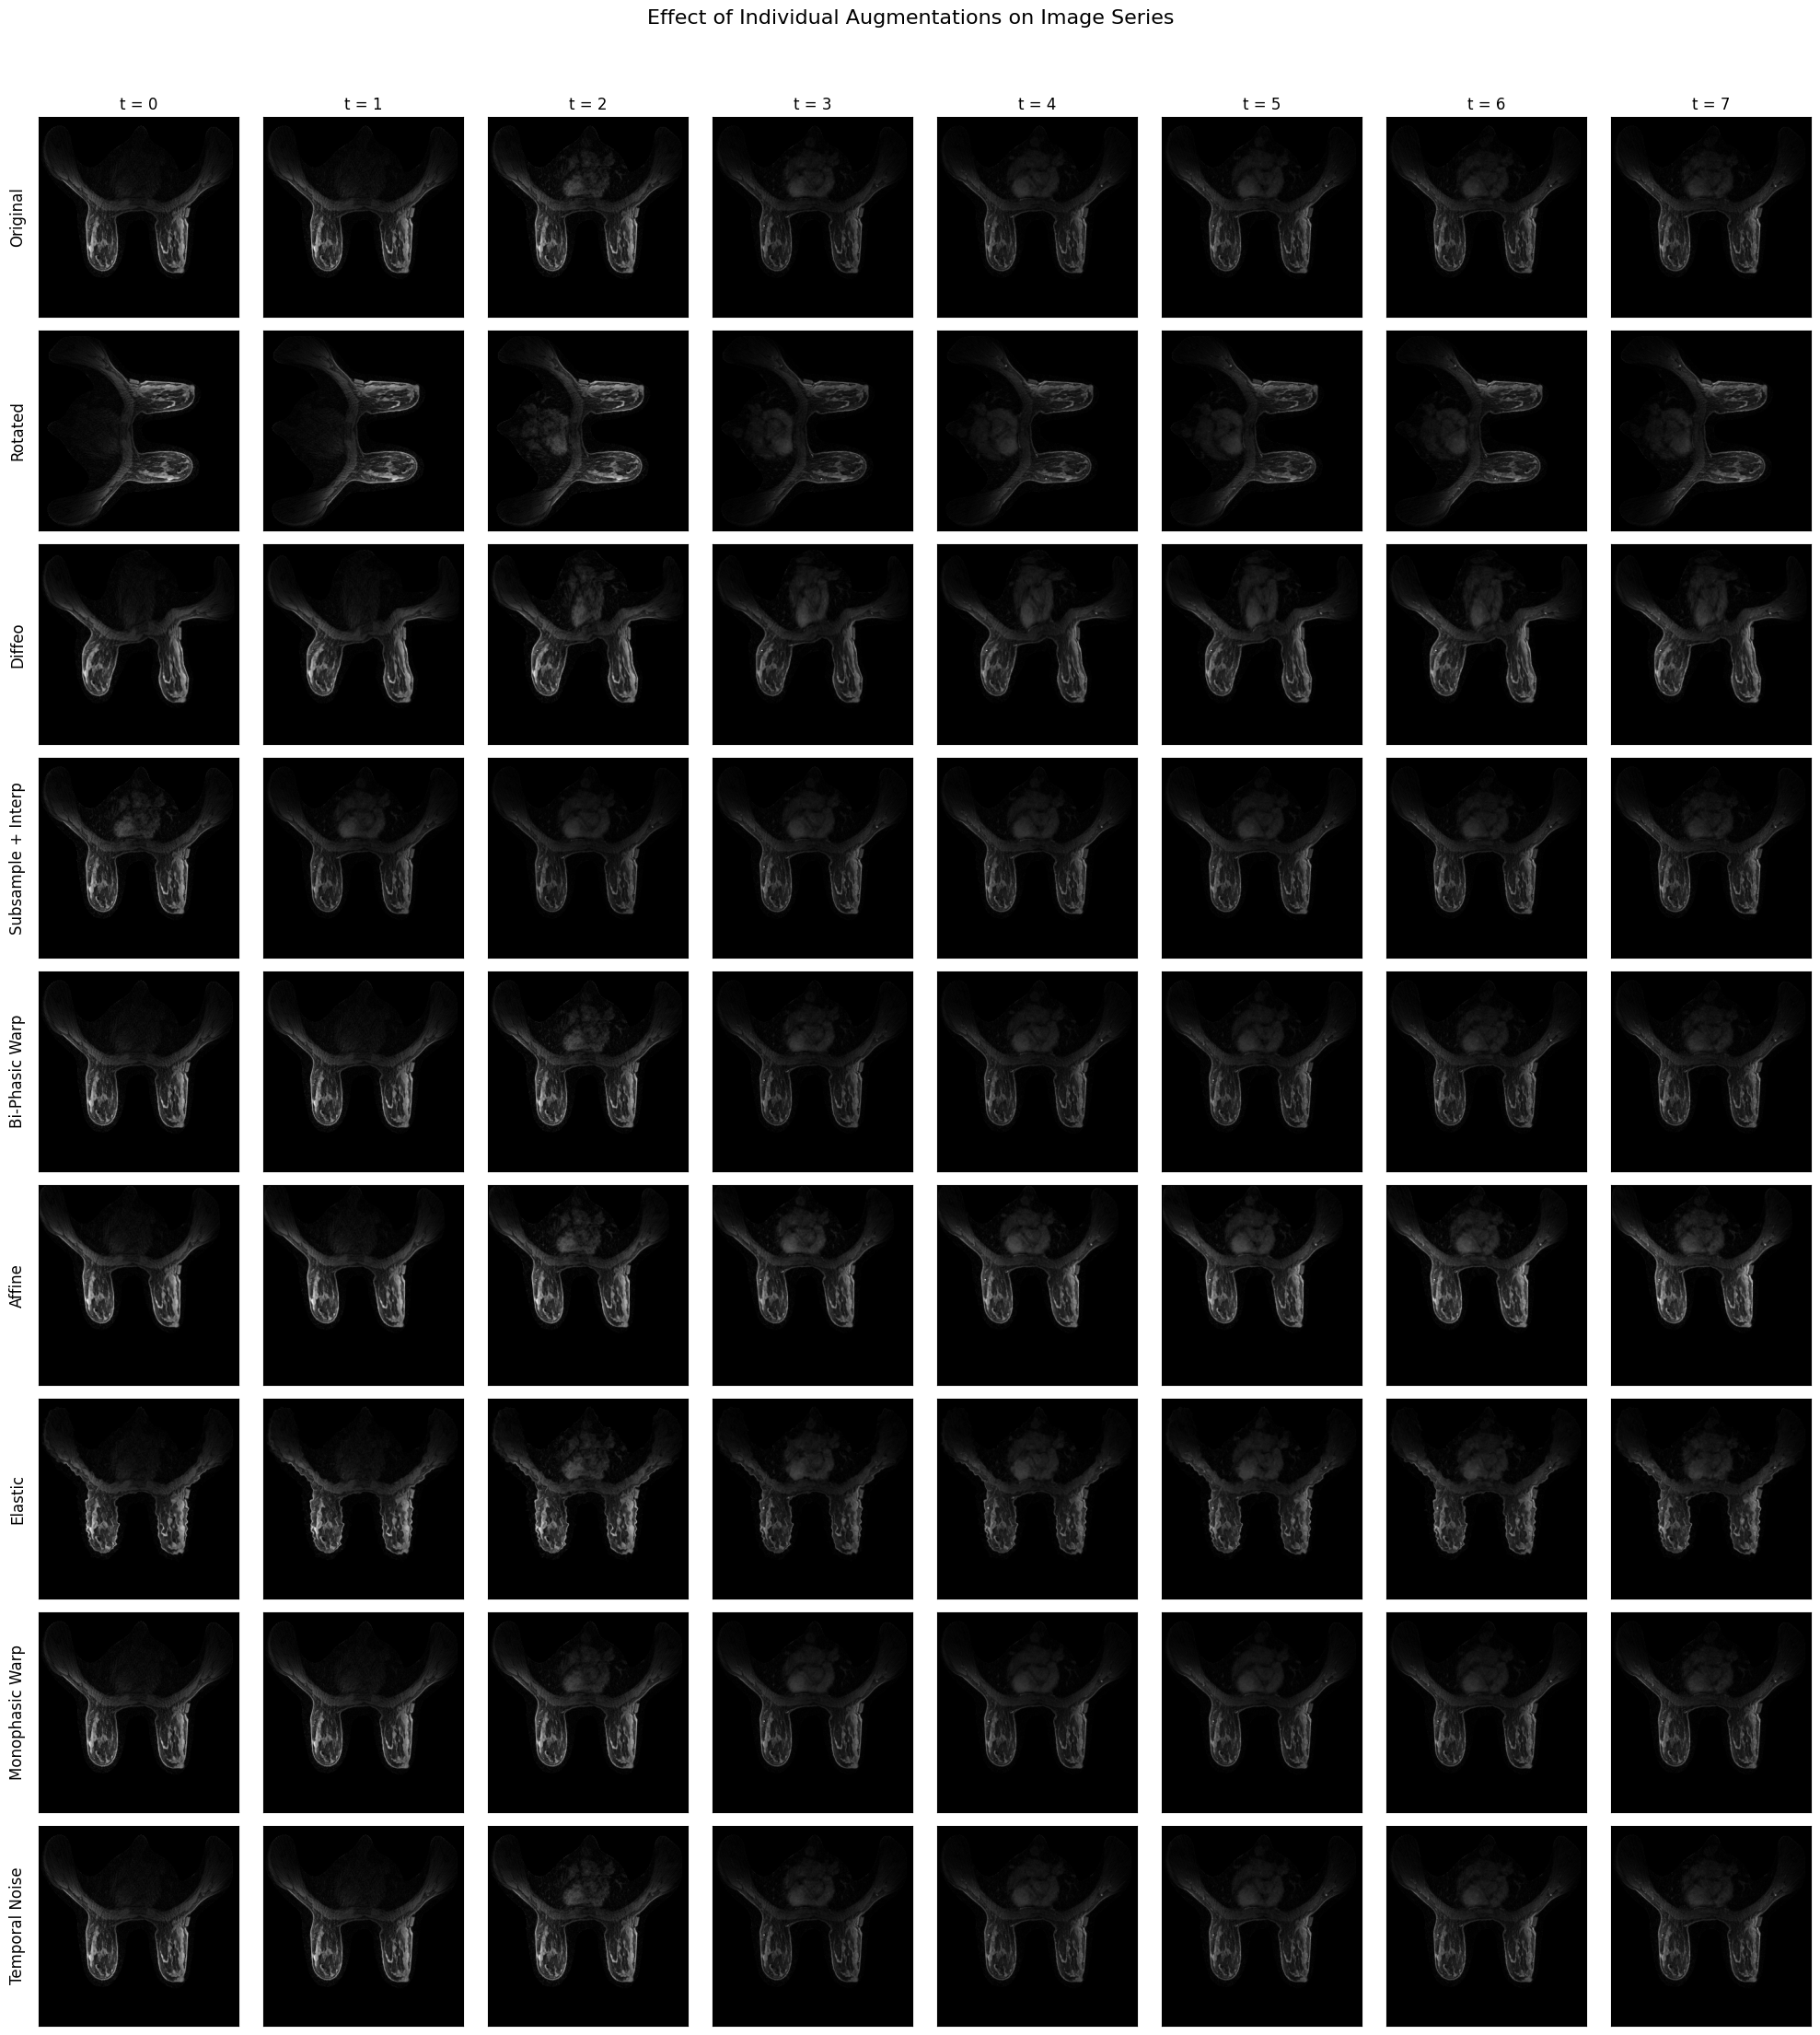

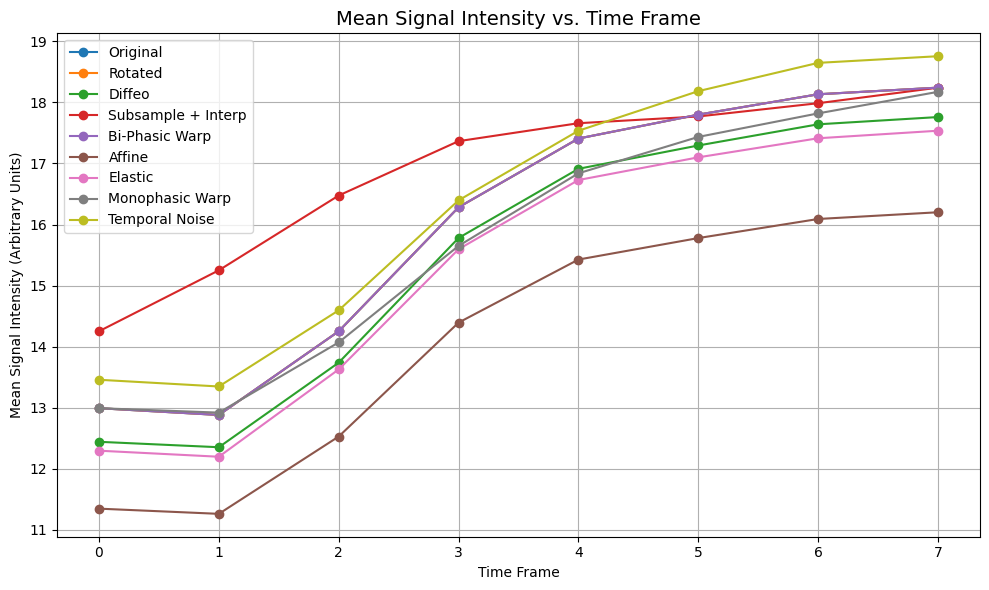

In [17]:
device = torch.device("cuda")

# --- 2. Load a Single Data Sample ---
# We use the GRASP image for visualization as it's the clean ground truth
dataset = SliceDataset(
    root_dir="/ess/scratch/scratch1/rachelgordon/dce-8tf/binned_kspace",
    patient_ids=['fastMRI_breast_001_2'], # Use a specific patient for reproducibility
    dataset_key="ktspace",
    file_pattern="*.h5",
    slice_idx=41,
)

_, original_image = dataset[0] # We get the grasp_img
original_image = original_image.unsqueeze(0).to(device) # Add batch dim and move to device

B, C, T, H, W = original_image.shape
print(f"Loaded original image with shape: (B={B}, C={C}, T={T}, H={H}, W={W})")

# --- 3. Instantiate Transformations ---
print("Instantiating transformations...")
rotate = VideoRotate(n_trans=1, interpolation_mode=InterpolationMode.BILINEAR)
diffeo = VideoDiffeo(n_trans=1, device=device, tps_scale=0.03,      # Drastically reduce non-rigid warping (default is 0.2)
    rot_scale=0.01,      # Reduce random rotation (default is 0.1)
    shear_scale=0.01,    # Reduce shearing (default is 0.1)
    trans_scale=0.01,    # Reduce translation (default is 0.1)
    n_control_points=10  # Use a reasonable number of control points
)
subsample = SubsampleTime(
    n_trans=1, 
    subsample_ratio_range=(0.7, 0.95)
)
biphasic_warp = PeakAwareBiPhasicWarp(
    n_trans=1, 
    warp_ratio_range=(0.6, 0.95)
)

affine = VideoAffine(
    n_trans=1,
    degrees=15,             # Rotate by +/- 15 degrees
    translate=(0.1, 0.1),   # Translate up to 10% of image height/width
    scale=(0.9, 1.1),       # Scale between 90% and 110%
    shear=5                 # Shear by +/- 5 degrees
)

elastic = VideoElastic(
    n_trans=1,
    alpha=10.0,             # A smaller value for subtle warping
    sigma=2.0               # A smaller sigma for more localized warping
)

monophasic_warp = MonophasicTimeWarp(
    n_trans=1, 
    warp_ratio_range=(0.7, 1.3) 
)

temp_noise = TemporalNoise(n_trans=1, warp_rationoise_strength_range=0.5)

# --- 4. Apply Transformations ---
# Use torch.no_grad() as we are not training
with torch.no_grad():
    print("Applying transformations...")
    rotated_image = rotate(original_image)
    diffeo_image = diffeo(original_image)
    subsampled_image = subsample(original_image)
    warped_image = biphasic_warp(original_image)
    affine_image = affine(original_image)
    elastic_image = elastic(original_image)
    monophasic_warp = monophasic_warp(original_image)
    temp_noise = temp_noise(original_image)

# Store all results in a dictionary for plotting
images_to_plot = {
    "Original": original_image,
    "Rotated": rotated_image,
    "Diffeo": diffeo_image,
    "Subsample + Interp": subsampled_image,
    "Bi-Phasic Warp": warped_image,
    "Affine": affine_image,
    "Elastic": elastic_image,
    "Monophasic Warp": monophasic_warp,
    "Temporal Noise": temp_noise
}

# --- 5. Generate Plots ---
plot_image_grid(images_to_plot, n_timeframes=T)
plot_signal_curves(images_to_plot)
